In [1]:
from xbbbNN import visualize_pockets, get_xb_bb_positions, get_network_features, small_network_evaluation, head_on_network_evaluation, get_best_orientations, get_bb_head_on_model_features, get_bb_side_on_model_features
from xbpy import rdutil
from xbbbNN import get_bb_head_on_features_from_molecule, get_bb_side_on_features_from_molecule
import numpy as np
import pymolviz as pmv
import tensorflow as tf
from matplotlib import pyplot as plt
import xbbbNN
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

2024-01-26 16:46:23.158275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 16:46:23.269170: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 16:46:23.694579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-26 16:46:23.694637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
model_system = next(rdutil.read_molecules("./structure_files/test_conformation.pdb"))

In [3]:
acceptor_atom = [atom for atom in model_system.GetAtoms() if atom.GetSymbol() == "O"][0]
halogen_atom = [atom for atom in model_system.GetAtoms() if atom.GetSymbol() in ["Cl", "Br", "I"]][0]
carbon_atom = [atom for atom in halogen_atom.GetNeighbors() if atom.GetSymbol() == "C"][0]

In [4]:
box_range = np.array([5.0]*3)
step_width = 0.5
def get_grid():
    bb_min, bb_max = - box_range, + box_range
    grid = np.mgrid[bb_min[0]:bb_max[0]:step_width, bb_min[1]:bb_max[1]:step_width, bb_min[2]:bb_max[2]:step_width]
    grid = grid.reshape(3, -1).T
    return grid

In [5]:
multi_features = get_bb_head_on_features_from_molecule(model_system, get_grid())
side_on_multi_features = get_bb_side_on_features_from_molecule(model_system, get_grid(), just_closest=True)

In [6]:
model_path = "/home/highgarden/Workspace/Thesis/XB_BB_Docking_Score/Data/Neural_Network/Weights/2,2,2-4,1-f2-it1"

In [7]:
model = tf.keras.models.load_model(model_path, compile=False)

2024-01-26 16:46:25.809850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
multi_features.T.shape

(9, 8000)

In [9]:
prediction = model.predict([np.zeros((8000, 114)), np.zeros((8000, 1)), side_on_multi_features, multi_features], verbose=0)

In [10]:
head_on_prediction = prediction[:, 2]

In [11]:
side_on_prediction = prediction[:, 1]

In [12]:
import pymolviz as pmv
grid_data = pmv.GridData(head_on_prediction, get_grid() + rdutil.position(halogen_atom), name="Head_on_prediction_grid")
grid_data_side_on = pmv.GridData(side_on_prediction, get_grid() + rdutil.position(halogen_atom), name="Side_on_prediction_grid")
head_on_volume = pmv.Volume(grid_data, name = "Head_on_prediction")
side_on_volume = pmv.Volume(grid_data_side_on, name = "Side_on_prediction")
pmv.Group([
    head_on_volume,
    side_on_volume,
    side_on_volume.colormap,
    grid_data,
    grid_data_side_on,
], name = "Predictions").write("predictions.py")

In [13]:
from xbbbNN import get_best_bb_head_on_orientations

(1217, 3) (1217, 3) (1217, 3)


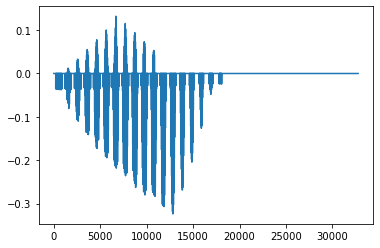

In [14]:
grid = [(x, y, z) for x in np.arange(-8, 8, .5) for y in np.arange(-8, 8, .5) for z in np.arange(-8, 8, .5)]
grid = np.array(grid)
positions, neighbor_positions, values = get_best_bb_head_on_orientations([acceptor_atom], grid + rdutil.position(halogen_atom),"I", 1.7, lambda x: np.nan_to_num(model.predict([np.zeros((x.shape[0], 114)), np.zeros((x.shape[0], 1)), np.zeros((x.shape[0], 19)), x], verbose=0)[:, 2]))
filter = values < -0.1
arrows = pmv.Arrows(np.hstack([neighbor_positions[filter], positions[filter]]), values[filter], name="Head_on_prediction_arrows")
pmv.Group([arrows, arrows.colormap], name="model_system_head_on_arrows").write("model_system_head_on_arrows.py")
plt.plot(values)

(29, 3) (29, 3) (29, 3)


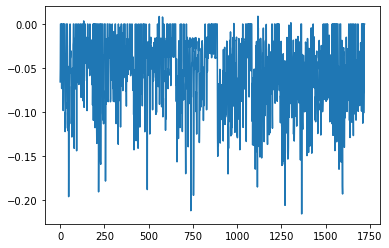

In [19]:
protein = next(rdutil.read_molecules("5nkd.pdb", proximityBonding=True))
pocket = rdutil.get_binding_pockets_by_ligand(protein)[0]
acceptor_atoms = [a for a in pocket.pocket_atoms if (a.GetPDBResidueInfo().GetName().strip() == "O") and (len(a.GetNeighbors()) == 1)]
positions, neighbor_positions, values = get_best_bb_head_on_orientations(acceptor_atoms, pocket.get_accessible_points(1),"Cl", 1.7, lambda x: np.nan_to_num(model.predict([np.zeros((x.shape[0], 114)), np.zeros((x.shape[0], 1)), np.zeros((x.shape[0], 19)), x], verbose=0)[:, 2]))
filter = values < -0.15
arrows = pmv.Arrows(np.hstack([neighbor_positions[filter], positions[filter]]), values[filter], name="Head_on_prediction_arrows", linewidth=.1)
pmv.Group([arrows, arrows.colormap], name="test_arrows").write("test_arrows.py")
plt.plot(values)

In [16]:
acceptor_positions = rdutil.position(acceptor_atoms)
test_positions = pmv.Points(acceptor_positions, name="Acceptor atoms",color="green").write("acceptor_positions.py")

In [17]:
pmv.Points(positions).write("test_positions.py")

In [18]:
grid = [(x, y, z) for x in np.arange(-8, 8, .5) for y in np.arange(-8, 8, .5) for z in np.arange(-8, 8, .5)]
grid = np.array(grid)
#grid = grid[np.linalg.norm(grid, axis = 1) > 2]

grid = np.array(grid) + backbone_center
arrows, best_scores = get_best_orientations(grid, head_on_network_evaluation, "Cl", 1.7, [a for a in backbone_system.GetAtoms() if a.GetSymbol() == "O"])


NameError: name 'backbone_center' is not defined

In [ ]:
test_coords =[ 6.158642,  -2.8019161, -0.8649455]
from xbpy import geometry
cone = geometry.sample_cone(np.array([ 0, 0, 1]), 1, np.pi, 0.5)
scores = head_on_network_evaluation(test_coords, cone, [a for a in backbone_system.GetAtoms() if a.GetSymbol() == "O"], "Cl", 1.7)
pmv.Points(-cone + test_coords, color = scores.flatten(), name = "cone").write("cone.py")


In [ ]:
test_coords =[ 6.158642,  -2.8019161, -0.8649455]
from xbpy import geometry
best_direction = cone[np.argmin(scores)]; best_direction /= np.linalg.norm(best_direction)
cone = geometry.sample_cone(best_direction, 1, np.pi/8, 0.1)
scores = head_on_network_evaluation(test_coords, cone, [a for a in backbone_system.GetAtoms() if a.GetSymbol() == "O"], "Cl", 1.7)
pmv.Points(-cone + test_coords, color = scores.flatten(), name = "cone_tightened").write("cone_tightened.py")



In [ ]:
cone[np.argmin(scores)]

array([ 0.75086239, -0.6147601 , -0.24140357])

In [ ]:
scores.shape
cone = geometry.sample_cone([1, 0, 0], 1, np.pi/8, 0.1)
pmv.Points(cone, color = "red", name = "cone_test").write("cone_test.py")


In [ ]:

#visualize(direct_network_application, "5nkd.pdb").write("direct_head_on_test.py")
visualize_pockets(head_on_network_evaluation, "5nkd.pdb").write("head_on_test_faulty.py")

100%|██████████| 1720/1720 [01:40<00:00, 17.15it/s]


(170, 3) (170, 3) (170, 3)
